In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm


# Set-up

## Load data

In [3]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Get class names
# imagenet_class_nums = np.arange(0, 1000, 1)
# imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# # Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)


# Patch/image-level analysis for maximally activating neurons

Look at maximally activating neurons with patch/image as the individual unit.

Loaded from precached activations from 500 randomly sampled ImageNet points.

In [4]:
import pandas as pd
import os

layer_num = 7

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name = f'mlp_fc1_{layer_num}.npz'

loaded = pd.read_parquet(os.path.join(save_path, file_name))


### Get standard deviation of patch value 

On the neuron level (aggregating across all images and patches for that neuron)**

In [5]:
# Calculate mean and standard deviation for 'activation_value' grouped by 'neuron_idx'
grouped = loaded.groupby('neuron_idx')['activation_value']
mean_per_neuron = grouped.transform('mean')
std_dev_per_neuron = grouped.transform('std')

# Calculate the z-score (number of standard deviations from the mean)
loaded['activation_value_sds'] = (loaded['activation_value'] - mean_per_neuron) / std_dev_per_neuron

# Replace NaN and infinite values (which can occur if std_dev is zero) with zero
loaded['activation_value_sds'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)


# Sort by z-score
sorted_df = loaded.sort_values(by=['activation_value_sds'], ascending=False)

### Visualize heatmap for specific image + neuron

In [6]:
import pandas as pd


def plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224, pixel_num=14):

    activation_values_array = activation_values_array.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

    # Plotting the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1,2,0))
    ax.imshow(heatmap, cmap='viridis', alpha=0.4)  # Overlaying the heatmap

    # Removing axes
    ax.axis('off')

    min_activation = activation_values_array.min()
    max_activation = activation_values_array.max()

    # Adding colorbar for the heatmap
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

    plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
    plt.show()




In [7]:
def get_image_and_activations_by_id(specific_neuron_idx, specific_image_idx):
    image, label = load_specific_image(imagenet_data, random_indices, specific_image_idx)

    filtered_df = loaded[(loaded['batch_idx'] == specific_image_idx) & 
                                (loaded['neuron_idx'] == specific_neuron_idx)]

    activation_values = filtered_df['activation_value_sds']

    activation_values_array = activation_values.to_numpy()[1:]

    return image, activation_values_array


# Load saved indices
random_indices = np.load('imagenet_sample_indices.npy')

# Function to load a specific image
def load_specific_image(dataset, indices, order):
    specific_index = indices[order]  # Subtract 1 because list indices start at 0
    image, label = dataset[specific_index]
    return image, label


Top 10 Unique Class Names: ['half_track', 'racket', 'flagpole', 'beacon', 'file', 'book_jacket', 'barbershop', 'slot', 'notebook', 'brass', 'beer_bottle', 'Chesapeake_Bay_retriever', 'turnstile', 'vending_machine', 'comic_book', 'Rottweiler', 'toy_terrier', 'upright', 'night_snake', 'desk', 'parking_meter', 'grocery_store', 'horse_cart', 'perfume', 'monitor', 'mountain_bike', 'theater_curtain', 'Model_T', 'beach_wagon', 'Sealyham_terrier']
Corresponding Activations: [2.2590324878692627, 2.113462209701538, 1.9172945022583008, 1.7346134185791016, 1.670760154724121, 1.513585090637207, 1.5052056312561035, 1.489551305770874, 1.468834638595581, 1.4519912004470825, 1.4365017414093018, 1.4248579740524292, 1.4006781578063965, 1.3812201023101807, 1.379358172416687, 1.3230383396148682, 1.257476568222046, 1.2358672618865967, 1.2314456701278687, 1.1592016220092773, 1.1192716360092163, 1.1163309812545776, 1.115774154663086, 1.1074552536010742, 1.0992162227630615, 1.086722731590271, 1.082387208938598

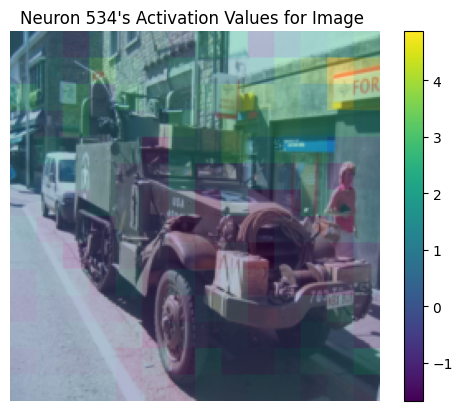

Class Name: half_track
Activation Value: 2.2590324878692627
Batch Index: 377



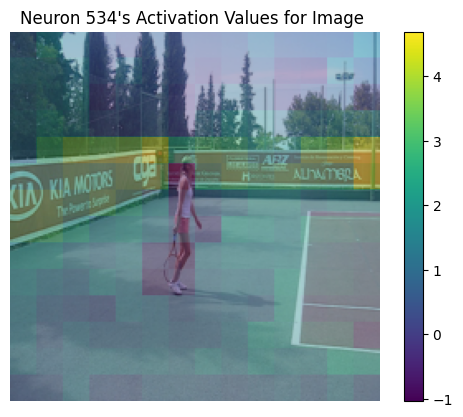

Class Name: racket
Activation Value: 2.113462209701538
Batch Index: 304



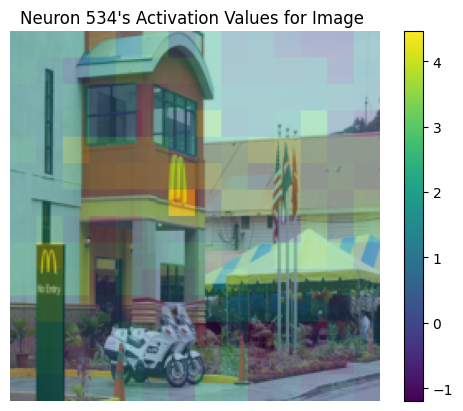

Class Name: flagpole
Activation Value: 1.9172945022583008
Batch Index: 332



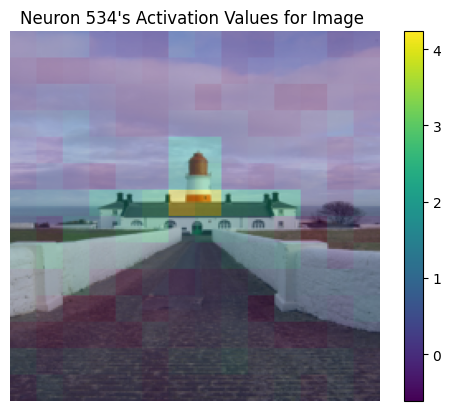

Class Name: beacon
Activation Value: 1.7346134185791016
Batch Index: 168



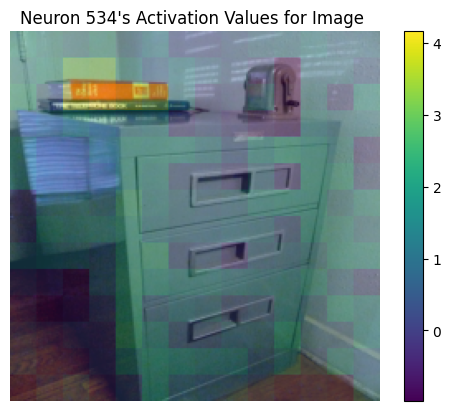

Class Name: file
Activation Value: 1.670760154724121
Batch Index: 499



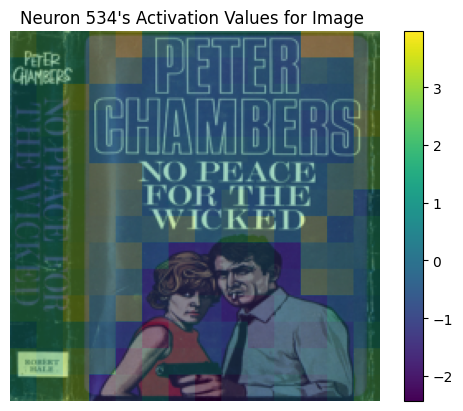

Class Name: book_jacket
Activation Value: 1.513585090637207
Batch Index: 475



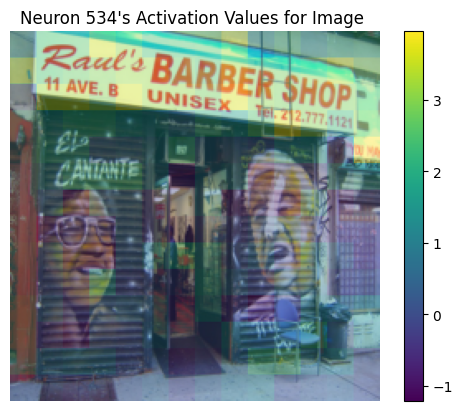

Class Name: barbershop
Activation Value: 1.5052056312561035
Batch Index: 243



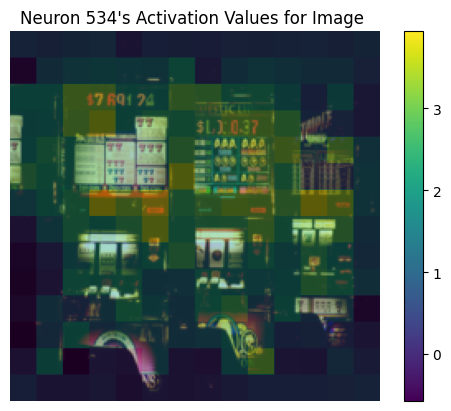

Class Name: slot
Activation Value: 1.489551305770874
Batch Index: 53



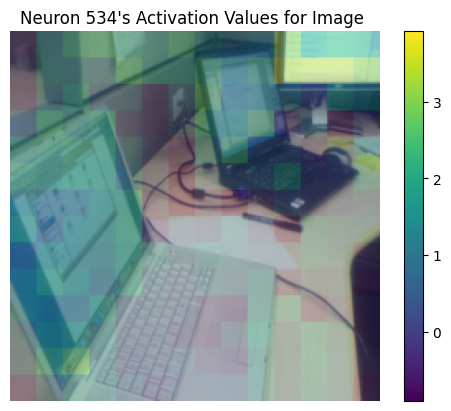

Class Name: notebook
Activation Value: 1.468834638595581
Batch Index: 240



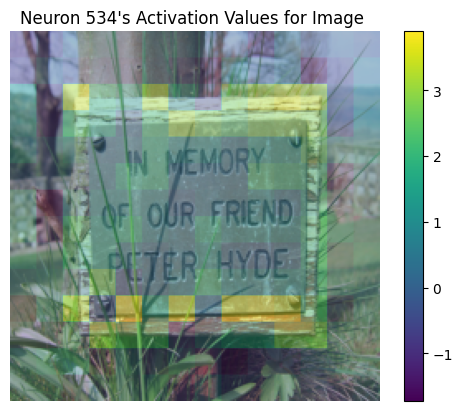

Class Name: brass
Activation Value: 1.4519912004470825
Batch Index: 62



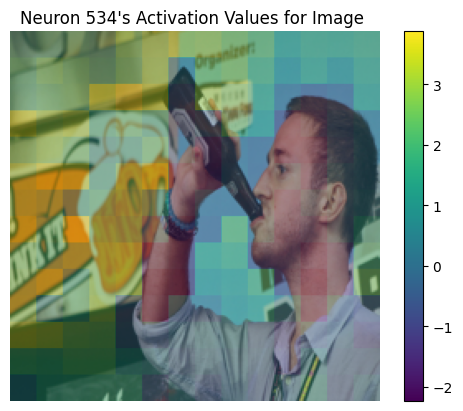

Class Name: beer_bottle
Activation Value: 1.4365017414093018
Batch Index: 125



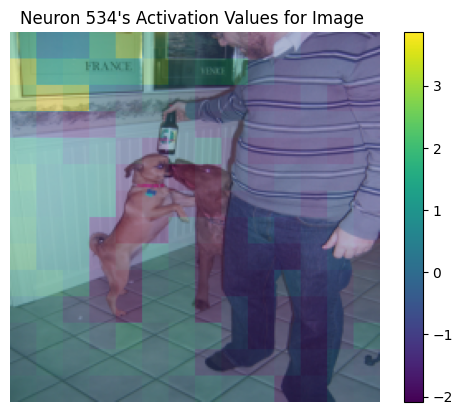

Class Name: Chesapeake_Bay_retriever
Activation Value: 1.4248579740524292
Batch Index: 291



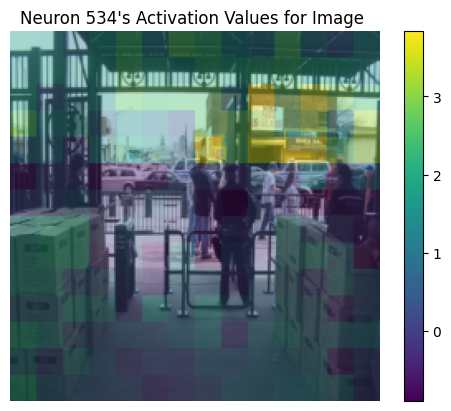

Class Name: turnstile
Activation Value: 1.4006781578063965
Batch Index: 282



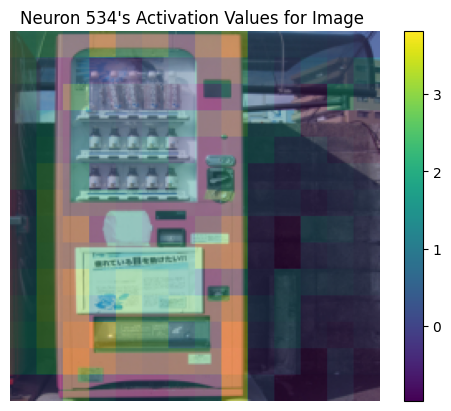

Class Name: vending_machine
Activation Value: 1.3812201023101807
Batch Index: 74



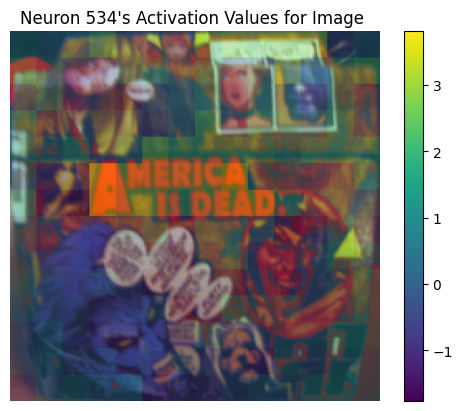

Class Name: comic_book
Activation Value: 1.379358172416687
Batch Index: 376



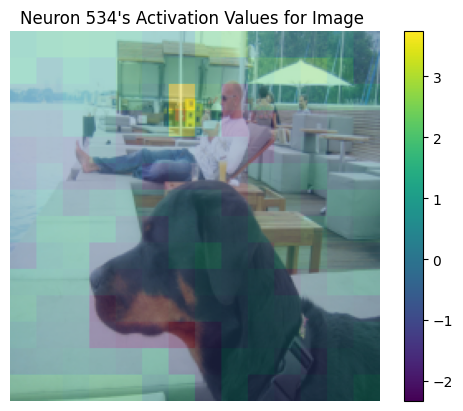

Class Name: Rottweiler
Activation Value: 1.3230383396148682
Batch Index: 395



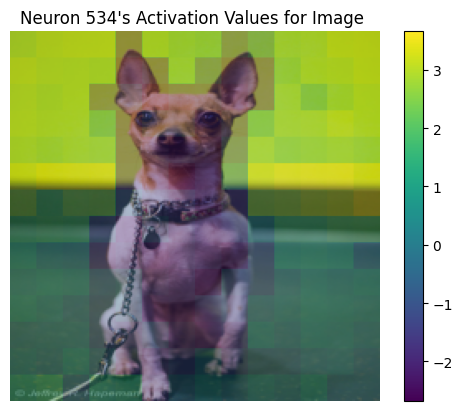

Class Name: toy_terrier
Activation Value: 1.257476568222046
Batch Index: 165



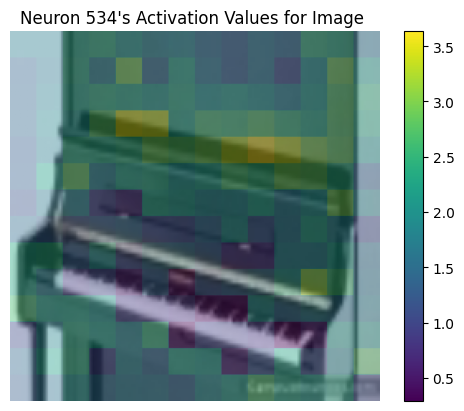

Class Name: upright
Activation Value: 1.2358672618865967
Batch Index: 308



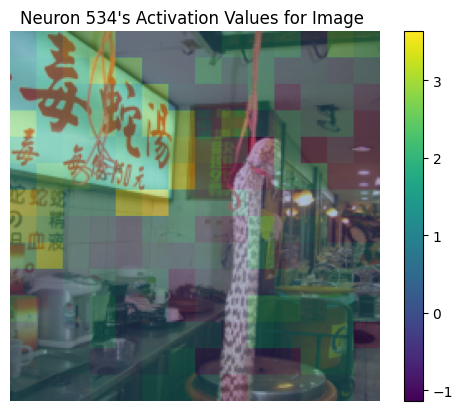

Class Name: night_snake
Activation Value: 1.2314456701278687
Batch Index: 301



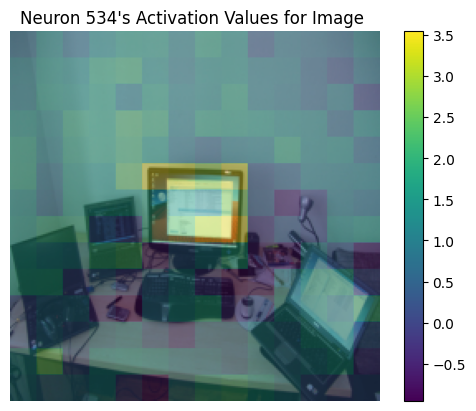

Class Name: desk
Activation Value: 1.1592016220092773
Batch Index: 47



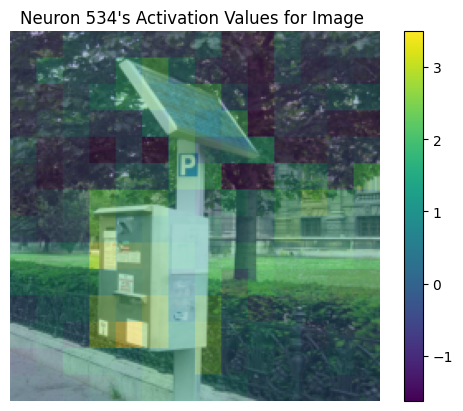

Class Name: parking_meter
Activation Value: 1.1192716360092163
Batch Index: 403



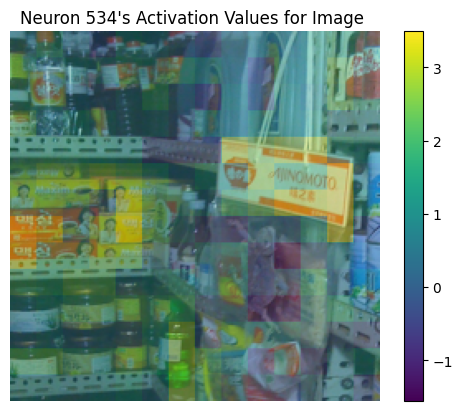

Class Name: grocery_store
Activation Value: 1.1163309812545776
Batch Index: 102



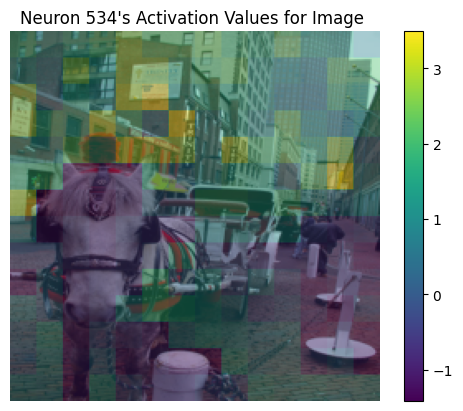

Class Name: horse_cart
Activation Value: 1.115774154663086
Batch Index: 27



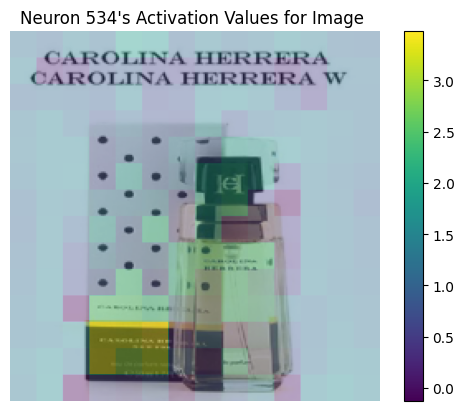

Class Name: perfume
Activation Value: 1.1074552536010742
Batch Index: 112



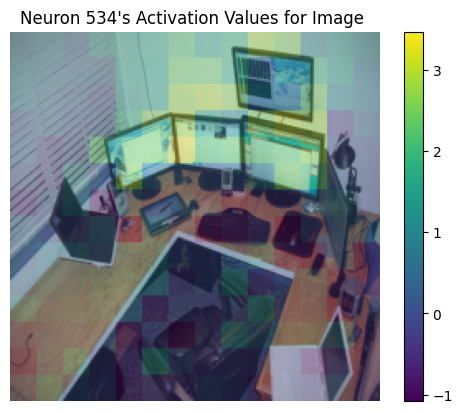

Class Name: monitor
Activation Value: 1.0992162227630615
Batch Index: 384



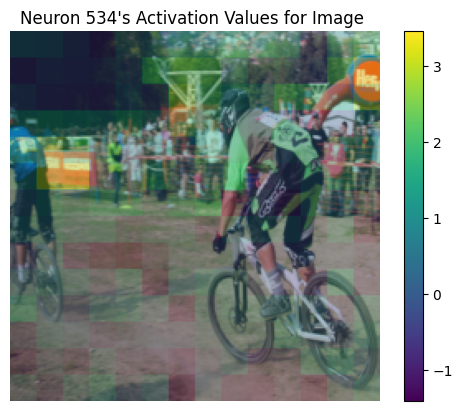

Class Name: mountain_bike
Activation Value: 1.086722731590271
Batch Index: 0



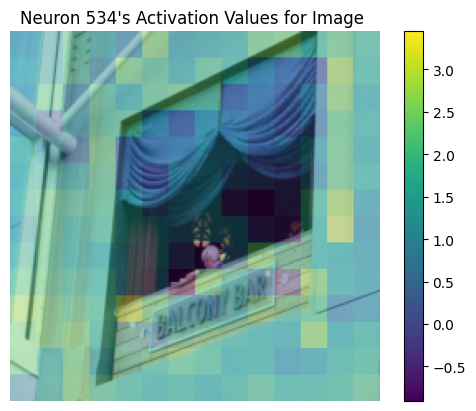

Class Name: theater_curtain
Activation Value: 1.0823872089385986
Batch Index: 262



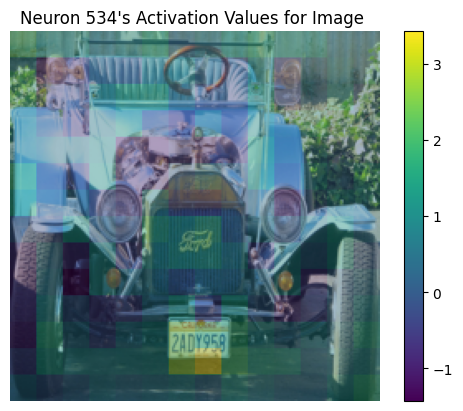

Class Name: Model_T
Activation Value: 1.0638866424560547
Batch Index: 111



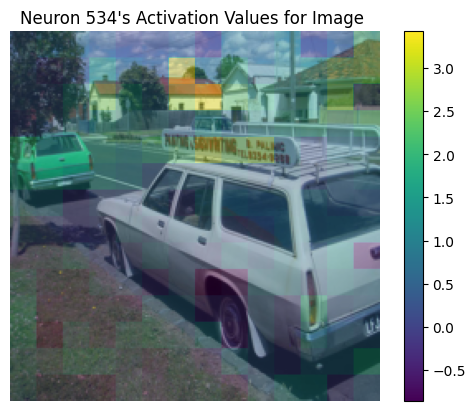

Class Name: beach_wagon
Activation Value: 1.0606482028961182
Batch Index: 145



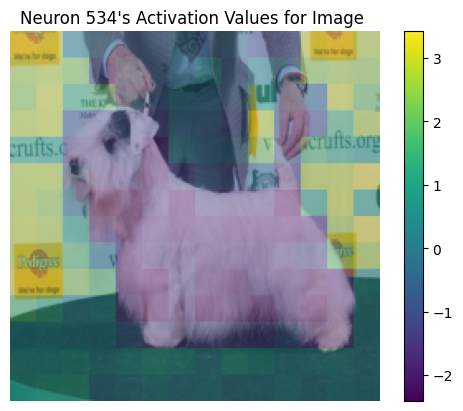

Class Name: Sealyham_terrier
Activation Value: 1.058213472366333
Batch Index: 420



In [16]:
# Get top 10 class names, no duplicates
import matplotlib.pyplot as plt

specific_neuron_idx = 534

unique_top_entries = sorted_df[sorted_df['neuron_idx'] == specific_neuron_idx].drop_duplicates(subset='class_name').head(30)

# Extracting class names and activation values
unique_top_class_names = unique_top_entries['class_name'].tolist()
unique_top_activations = unique_top_entries['activation_value'].tolist()
unique_top_batch_idx = unique_top_entries['batch_idx'].tolist()

# Lists are ready to use
print("Top 10 Unique Class Names:", unique_top_class_names)
print("Corresponding Activations:", unique_top_activations)
print("Corresponding Batch Indices:", unique_top_batch_idx)


# Now plot

for i, batch_idx in enumerate(unique_top_batch_idx):
    image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, batch_idx)
    plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)
    print("Class Name:", unique_top_class_names[i])
    print("Activation Value:", unique_top_activations[i])
    print("Batch Index:", unique_top_batch_idx[i])
    print("")
# image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, unique_top_batch_idx[0])
# plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)

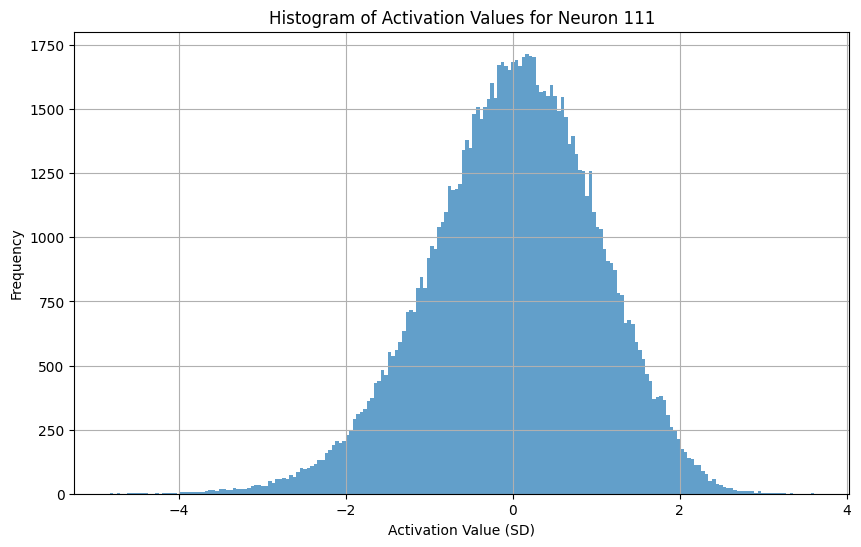

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# Should this be in log scale?



# Filter the DataFrame to only include the neuron of interest
filtered_df = loaded[loaded['neuron_idx'] == specific_neuron_idx]

# Create a histogram of the activation values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['activation_value_sds'], bins=200, alpha=0.7)
plt.title(f'Histogram of Activation Values for Neuron {specific_neuron_idx}')
plt.xlabel('Activation Value (SD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Do this in log scale? 
